In [2]:
import matplotlib.pyplot as plt
import numpy as np
# import pandas as pd
import os
from sklearn.model_selection import KFold
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# import time
# from contextlib import contextmanager # timer
# from functools import partial
import cv2
# import seaborn as sns
# import SimpleITK as sitk
import matplotlib.pylab as plt
from sklearn.model_selection import KFold
import random
from skimage.transform import rescale, resize
from scipy.ndimage import rotate
# import torch
# from torch.utils import data
# from torch.utils.data import DataLoader, Dataset
import SimpleITK as sitk
print(os.listdir("../input/"))
# from skimage import data, img_as_float
from skimage import exposure
import tensorflow as tf

2023-07-25 15:16:35.878264: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
def batch_generator(batch_size, gen_x): 
    batch_features = np.zeros((batch_size,256,256,3))
    batch_labels = np.zeros((batch_size,256,256,3)) 
    print(batch_size)
    while True:
        for i in range(batch_size):
            batch_features[i] , batch_labels[i] = next(gen_x)
        yield batch_features, batch_labels
    

In [4]:
def gaussian_noise(img, mean=0, sigma=0.03):
    img = img.copy()
    noise = np.random.normal(mean, sigma, img.shape)
    mask_overflow_upper = img+noise >= 1.0
    mask_overflow_lower = img+noise < 0
    noise[mask_overflow_upper] = 1.0
    noise[mask_overflow_lower] = 0
    img += noise
    return img

#https://towardsdatascience.com/complete-image-augmentation-in-opencv-31a6b02694f5
def brightness(img, low, high):
    value = random.uniform(low, high)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    hsv = np.array(hsv, dtype = np.float64)
    hsv[:,:,1] = hsv[:,:,1]*value
    hsv[:,:,1][hsv[:,:,1]>255]  = 255
    hsv[:,:,2] = hsv[:,:,2]*value 
    hsv[:,:,2][hsv[:,:,2]>255]  = 255
    hsv = np.array(hsv, dtype = np.uint8)
    img = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    return img

#https://towardsdatascience.com/complete-image-augmentation-in-opencv-31a6b02694f5
def fill(img, h, w):
    img = img.astype('float32')
    img = cv2.resize(img, (h, w), cv2.INTER_CUBIC)
    return img
def zoom(img, mask, value):
    if value > 1 or value < 0:
        print('Value for zoom should be less than 1 and greater than 0')
        return img, mask
    value = random.uniform(value, 1)
    h, w = img.shape[:2]
    h_taken = int(value*h)
    w_taken = int(value*w)
    h_start = random.randint(0, h-h_taken)
    w_start = random.randint(0, w-w_taken)
    img = img[h_start:h_start+h_taken, w_start:w_start+w_taken, :]
    img = fill(img, h, w)
    mask = mask[h_start:h_start+h_taken, w_start:w_start+w_taken, :]
    mask = fill(mask, h, w)
    return img, mask

# https://towardsdatascience.com/complete-image-augmentation-in-opencv-31a6b02694f5
def vertical_shift(img, mask, ratio=0.0):
    if ratio > 1 or ratio < 0:
        print('Value should be less than 1 and greater than 0')
        return img, mask
    ratio = random.uniform(-ratio, ratio)
    h, w = img.shape[:2]
    to_shift = h*ratio
    if ratio > 0:
        img = img[:, :int(w-to_shift), :]
        mask = mask[:, :int(w-to_shift), :]
    if ratio < 0:
        img = img[:, int(-1*to_shift):, :]
        mask = mask[:, int(-1*to_shift):, :]
    img = fill(img, h, w)
    mask = fill(mask, h, w)
    return img, mask

# https://towardsdatascience.com/complete-image-augmentation-in-opencv-31a6b02694f5 
def horizontal_shift(img, mask, ratio=0.0):
    if ratio > 1 or ratio < 0:
        print('Value should be less than 1 and greater than 0')
        return img, mask
    ratio = random.uniform(-ratio, ratio)
    h, w = img.shape[:2]
    to_shift = w*ratio
    if ratio > 0:
        img = img[:, :int(w-to_shift), :]
        mask = mask[:, :int(w-to_shift), :]
    if ratio < 0:
        img = img[:, int(-1*to_shift):, :]
        mask = mask[:, int(-1*to_shift):, :]
    img = fill(img, h, w)
    mask = fill(mask, h, w)
    return img,mask

In [5]:
def generate_data(filelist, img_path, mask_path, gen_type = "train"):
    while True:
        for i in filelist:
            X_train = cv2.imread(img_path + i, cv2.IMREAD_COLOR )
            X_train = cv2.resize(X_train, (256,256), interpolation= cv2.INTER_LINEAR )
            y_mask = cv2.imread(mask_path + i, cv2.IMREAD_COLOR)
            y_mask = cv2.resize(y_mask, (256,256), interpolation= cv2.IMREAD_GRAYSCALE)
            _,y_mask = cv2.threshold(y_mask, 127, 255, cv2.THRESH_BINARY)
            y_train = (y_mask/255).astype(int)
            if gen_type == "train":
                # returns a random integer used to select augmentataion techniques for a given sample
                augment_num = np.random.randint(0,9)
                if augment_num == 0:
                    # do nothing
                    X_train = X_train
                elif augment_num == 1:
                    #random noise
                    X_train = X_train + np.random.rand(X_train.shape[0], X_train.shape[1], X_train.shape[2])*np.random.randint(-100,100)
                elif augment_num == 2:
                    X_train = cv2.GaussianBlur(X_train,(random.randrange(1,50,2),random.randrange(1,50,2)), 0)
                elif augment_num == 3:
                    rot = np.random.randint(-45,45)
                    X_train = rotate(X_train,rot, reshape=False)
                    y_train = rotate(y_train,rot, reshape=False)
                elif augment_num == 4:
                    X_train = brightness(X_train,0.5,3)
                elif augment_num == 5:
                    X_train = np.fliplr(X_train)
                    y_train = np.fliplr(y_train)
                elif augment_num == 6:
                    X_train = np.flipud(X_train)
                    y_train = np.flipud(y_train)
                elif augment_num == 7:
                    hshift = round(random.uniform(0.1, 0.3),3)
                    X_train, y_train = horizontal_shift(X_train, y_train, hshift)
                elif augment_num == 8:
                    vshift = round(random.uniform(0.1, 0.3),3)
                    X_train, y_train = vertical_shift(X_train, y_train, vshift)
                elif augment_num == 9:
                    zoom_rate = round(random.uniform(0.8, 0.95),3)
                    X_train, y_train = zoom(X_train, y_train, zoom_rate)
                elif augment_num == 10:
                    #contrast
                    X_train = exposure.equalize_adapthist(X_train.astype(int), clip_limit=0.03)  
                elif augment_num == 11:
                    #contrast
                    X_train = exposure.equalize_hist(X_train.astype(int))  
            yield X_train, y_train

In [6]:
def generate_data_pred(filelist, img_path, mask_path, gen_type = "train"):
    while True:
        for i in filelist:
            original_img = cv2.imread(img_path + i, cv2.IMREAD_COLOR )
            X_train = cv2.resize(original_img, (256,256), interpolation= cv2.INTER_LINEAR )
            if gen_type == "train":
                X_train = X_train * np.random.choice([1,1,1,np.random.rand(256, 256,3)])
            original_mask = cv2.imread(mask_path + i, cv2.IMREAD_COLOR)
            y_mask = cv2.resize(original_mask, (256,256), interpolation= cv2.IMREAD_GRAYSCALE)
            _,y_mask = cv2.threshold(y_mask, 127, 255, cv2.THRESH_BINARY)
            y_mask = (y_mask/255).astype(int)
            yield original_img, original_mask, X_train, y_mask

In [7]:
def dice_score(mask_gt, mask_pred):
    """Computes soerensen-dice coefficient.

    compute the soerensen-dice coefficient between the ground truth mask `mask_gt`
    and the predicted mask `mask_pred`.

    Args:
    mask_gt: 3-dim Numpy array of type bool. The ground truth mask.
    mask_pred: 3-dim Numpy array of type bool. The predicted mask.

    Returns:
    the dice coeffcient as float. If both masks are empty, the result is NaN.
    """
    volume_sum = mask_gt.sum() + mask_pred.sum()
    if volume_sum == 0:
        return np.NaN
    volume_intersect = (mask_gt & mask_pred).sum()
    return 2*volume_intersect / volume_sum 

In [8]:
from keras import backend as K
# From: https://gist.github.com/wassname/7793e2058c5c9dacb5212c0ac0b18a8a
def dice_coef(y_true, y_pred, smooth=1):
    """
    Dice = (2*|X & Y|)/ (|X|+ |Y|)
         =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
    ref: https://arxiv.org/pdf/1606.04797v1.pdf
    """
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection + smooth) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [9]:
def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)


def jacard_coef_loss(y_true, y_pred):
    return 1-jacard_coef(y_true, y_pred)

In [10]:
from tensorflow.keras import layers
import tensorflow as tf


def get_model(img_size, num_classes):

    inputs = tf.keras.Input(shape=img_size + (3,))
    #inputs = tf.keras.Input(shape=(256,256,3))
    #inputs = tf.keras.Input(shape=img_size + (1,))
    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="sigmoid", padding="same")(x)

    # Define the model
    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=jacard_coef_loss, metrics = [jacard_coef, dice_coef])
    return model


# Free up RAM in case the model definition cells were run multiple times
tf.keras.backend.clear_session()

# Build model
#model = get_model(img_size, num_classes)

#model.summary()

In [11]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.1, patience=3, verbose=1, mode='min',
    min_delta=0.0001, cooldown=5, min_lr=0
)

In [12]:
%pip install segmentation-models==1.0.1

Note: you may need to restart the kernel to use updated packages.


In [10]:
%env SM_FRAMEWORK=tf.keras

env: SM_FRAMEWORK=tf.keras


In [14]:
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [15]:
from sklearn.metrics import jaccard_score
import time

In [16]:
file_list = np.asarray(os.listdir("../input/Kvasir-SEG/images/"))
image_path = "../input/Kvasir-SEG/images/" 
mask_path = "../input/Kvasir-SEG/masks/"

checkpoint_path = "./Checkpoint/"
checkpoint_dir = os.path.dirname(checkpoint_path)




# run = neptune.init(project='SSCP/HyperKvasir',
                #    api_token='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIzMGUyN2Q2ZS05MjVkLTRlMzItODYwZS0yODQ3ZWU3ZTdmMmEifQ==') # your credentials


batchsize = 2
data_size = len(file_list)
num_epoch = 30
splits = 10
kf = KFold(n_splits=splits)
valsize = data_size // splits
trainsize = data_size - valsize
my_model = "efficientnetb1"
data_num = np.arange(data_size)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1
                                                 ,save_freq=5*450)
# for train_index, val_index in kf.split(data_num):
#     print(train_index)

In [17]:


img_size = (256, 256)
num_classes = 3

# run["Dataset"] = "Polyp"
# run["Model"] = my_model
# run["CV-folds"] = splits
# run["Epochs"] = num_epoch
# run["Batch size"] = batchsize
# run["pretrained"] = "Imagenet"
# ##########################################################################################
# # Check what augmentation techniques you use and say "yes" or "no" in the fields bellow  #
# # You can also add new fields                                                            #
# ##########################################################################################
# run["noise"] = "yes"
# run["blurring"] = "yes"
# run["cropping"] = "no"
# run["flipping"] = "yes"
# run["rotation"] = "yes"
# run["zoom"] = "yes"
# run["translation"] = "no"
# run["brightness"] = "yes"
# run["contrast_hist"] = "no"
# run["contrast_adaptive"] = "no"
# run["color augmentation"] = "no"
# run["saturation"] ="no"
# run["horizontal shift"] = "yes"
# run["vertical shift"] = "yes"

validation_dice_original = np.zeros([valsize,splits])
validation_dice_resized = np.zeros([valsize,splits])
#validation_jaccard_original = np.zeros([valsize,splits])
#validation_jaccard_resized = np.zeros([valsize,splits])
training_indexes = [] 
validation_indexes = []
for train_index, val_index in kf.split(data_num):
    training_indexes.append(train_index)
    validation_indexes.append(val_index)
    

In [18]:
f = open("counter.txt", "r")
cv_count = int(f.read())
f.close()
print(cv_count)


10


In [19]:
model = sm.Unet(my_model, encoder_weights='imagenet', input_shape=( 256,256, 3), classes=3, activation='sigmoid')
model.load_weights(checkpoint_path)
model.compile(optimizer='Adam', loss=jacard_coef_loss, metrics = [jacard_coef, dice_coef])

train = False



while(0 <= cv_count < 10 and train == True):
    train_index = training_indexes[cv_count]
    val_index = validation_indexes[cv_count]
    model.fit(x=batch_generator(batchsize, generate_data(file_list[train_index], image_path, mask_path, gen_type = "train")), epochs=num_epoch, 
                            steps_per_epoch=(trainsize/batchsize), 
                            validation_steps=(valsize/batchsize),
                            validation_data=batch_generator(batchsize, generate_data(file_list[val_index], image_path, mask_path, gen_type = "val")), 
                            validation_freq=1, 
                            verbose = 1, 
                            callbacks=[reduce_lr,cp_callback],
                            )
    val_gen  = generate_data_pred(file_list[val_index], image_path, mask_path, gen_type = "val")
    for i in range(valsize):
        time_start = time.time()
        original_img, original_mask, X, y_true = next(val_gen)
        original_shape = original_img.shape
        y_pred = model.predict(np.expand_dims(X,0))
        _,y_pred_thr = cv2.threshold(y_pred[0,:,:,0]*255, 127, 255, cv2.THRESH_BINARY)
        y_pred = (y_pred_thr/255).astype(int)
        dice_resized = dice_score(y_true[:,:,0],y_pred)
        #jaccard_resized = jaccard_score(y_true[:,:,0],y_pred, average="macro")
        
        y_pred_original = cv2.resize(y_pred.astype(float), (original_shape[1],original_shape[0]), interpolation= cv2.INTER_LINEAR)
        dice_original = dice_score(original_mask[:,:,0],y_pred_original.astype(int)*255)
        #jaccard_original = jaccard_score(original_mask[:,:,0],y_pred_original.astype(int)*255, average="macro")
        
        validation_dice_original[i,cv_count] = dice_original
        validation_dice_resized[i,cv_count] = dice_resized
        #validation_jaccard_original[i,cv_count] = jaccard_original
        #validation_jaccard_resized[i,cv_count] = jaccard_resized
        
        if i < 5:
            plt.figure(figsize=(20,10))
            plt.subplot(1,2,1)
            plt.imshow(original_img, 'gray', interpolation='none')
            plt.imshow(original_mask/255.0, 'jet', interpolation='none', alpha=0.4)
            plt.subplot(1,2,2)
            # use this part to show the guessed img
            plt.imshow(original_img, 'gray', interpolation='none')
            plt.imshow(y_pred_original, 'jet', interpolation='none', alpha=0.4)
            plt.show()
    
        dice_resized_mean = validation_dice_resized[:,cv_count].mean()
        dice_original_mean = validation_dice_original[:,cv_count].mean()
        #jaccard_resized_mean = validation_jaccard_resized[:,cv_count].mean()
        #jaccard_original_mean = validation_jaccard_original[:,cv_count].mean()
            
        print("--------------------------------------")
        print("Mean validation DICE (on resized data):", dice_resized_mean) 
        print("Mean validation DICE (on original data):", dice_original_mean)
        print("--------------------------------------")
        #print("Mean validation Jaccard (on resized data):", jaccard_resized_mean) 
        #print("Mean validation Jaccard (on original data):", jaccard_original_mean)
        #print("--------------------------------------")
        # run["Dice Resized"].log(dice_resized_mean)
        # run["Dice Original"].log(dice_original_mean)
        #run["Jaccard Resized"].log(jaccard_resized_mean)
        #run["Jaccard Original"].log(jaccard_original_mean)
        runtime = time.time() - time_start 
        print('Runtime: {} sec'.format(runtime))
        # run["Runtime"] = runtime
    f = open("counter.txt", "w")
    cv_count +=1
    f.write(str(cv_count))
    f.close()
    print("cv_count is: " + str(cv_count))
        
# run.stop()

2023-07-25 15:16:41.929413: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-25 15:16:42.331407: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-25 15:16:42.331478: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-25 15:16:42.341104: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-25 15:16:42.341188: I tensorflow/compile

In [20]:
def predict(img_name):
    f = os.path.join('/home/wni1717/dev/OTUMEDAI/medai2021-polypixel/input/Kvasir-SEG/images/', img_name)
    x = cv2.imread(f, cv2.IMREAD_COLOR )
    x = cv2.resize(x, (256,256), interpolation= cv2.INTER_LINEAR )
    original_shape = x.shape
    print(original_shape[1])
    y_pred = model.predict(np.expand_dims(x,0))
    _,y_pred_thr = cv2.threshold(y_pred[0,:,:,0]*255, 127, 255, cv2.THRESH_BINARY)
    y_pred = (y_pred_thr/255).astype(int)
    print(y_pred)
    y_pred_original = cv2.resize(y_pred.astype(float), (original_shape[1],original_shape[0]), interpolation= cv2.INTER_LINEAR)
    plt.imshow(x, 'gray', interpolation='none')
    plt.imshow(y_pred_original, 'jet', interpolation='none', alpha=0.4)
    plt.show()
def original_mask(img_name):
    f_masks = os.path.join('/home/wni1717/dev/OTUMEDAI/medai2021-polypixel/input/Kvasir-SEG/masks/', img_name)
    f_img = os.path.join('/home/wni1717/dev/OTUMEDAI/medai2021-polypixel/input/Kvasir-SEG/images/', img_name)
    img = cv2.imread(f_img, cv2.IMREAD_COLOR )
    img = cv2.resize(img, (256,256), interpolation= cv2.INTER_LINEAR )
    mask = cv2.imread(f_masks, cv2.IMREAD_COLOR )
    mask = cv2.resize(mask, (256,256), interpolation= cv2.INTER_LINEAR )
    plt.imshow(img, 'gray', interpolation='none')
    plt.imshow(mask/255.0, 'jet', interpolation='none', alpha=0.4)
    

256
1/1 [==============================] - 0s 58ms/step
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


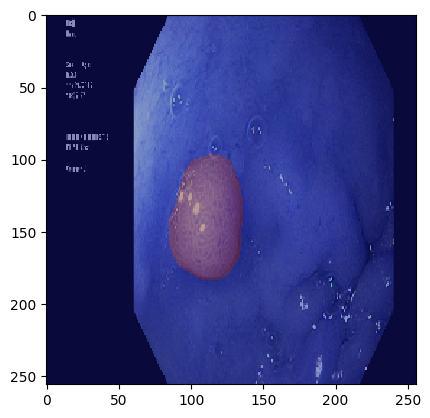

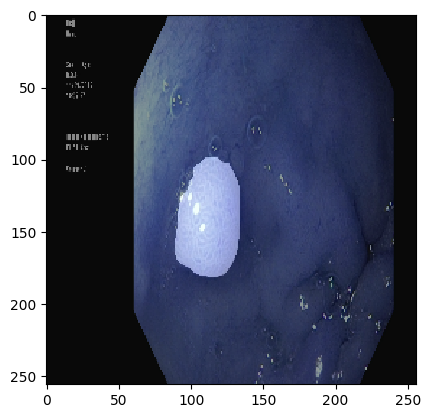

In [23]:
inp = 'cjyzul1qggwwj07216mhiv5sy.jpg'
predict(inp)
original_mask(inp)


In [8]:
!export SM_FRAMEWORK=tf.keras

['non_training', 'Kvasir-SEG']
1/1 [==============================] - 1s 1s/step


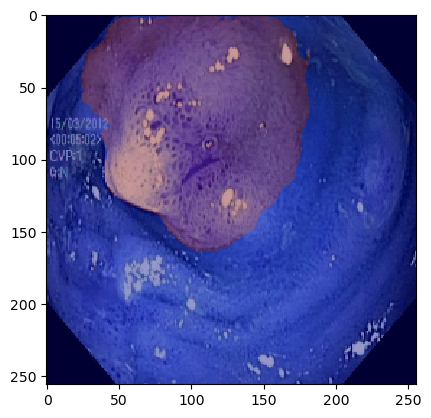

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.model_selection import KFold
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import segmentation_models as sm

from sklearn.model_selection import KFold
from skimage.transform import rescale, resize
from scipy.ndimage import rotate
print(os.listdir("../input/"))
import tensorflow as tf
from tensorflow.keras import layers

input_path = input("please enter the path to the image: ")

checkpoint_path = "./Checkpoint/"
checkpoint_dir = os.path.dirname(checkpoint_path)

my_model = "efficientnetb1"

model = sm.Unet(my_model, encoder_weights='imagenet', input_shape=( 256,256, 3), classes=3, activation='sigmoid')
model.load_weights(checkpoint_path)
model.compile(optimizer='Adam') # changed from original
x = cv2.imread(input_path, cv2.IMREAD_COLOR)
x = cv2.resize(x, (256,256), interpolation= cv2.INTER_LINEAR)
original_shape = x.shape
y_pred = model.predict(np.expand_dims(x,0))
_,y_pred_thr = cv2.threshold(y_pred[0,:,:,0]*255, 127, 255, cv2.THRESH_BINARY)
y_pred = (y_pred_thr/255).astype(int)
y_pred_original = cv2.resize(y_pred.astype(float), (original_shape[1],original_shape[0]), interpolation= cv2.INTER_LINEAR)
plt.imshow(x, 'gray', interpolation='none')
plt.imshow(y_pred_original, 'jet', interpolation='none', alpha=0.4)
plt.savefig("/home/wni1717/dev/OTUMEDAI/OTUAILIB/models/Segmentation/output/test.png", format = "png")
